# Local Model-Agnostic Methods

Local models focus on interpreting individual predictions and how changes affect the outcome of that specific prediction. Model-agnostic means that the methods can be applied to any model type, typically focusing on post-model creation explanation

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 05/05/2025   | Martin | Created   | Notebook created for section 2. Started on Ceteris Paribus Plots | 
| 06/05/2025   | Martin | Created   | Completed Ceteris Paribus Plots. Started ICE | 

# Content

* [Ceteris Paribus Plots](#ceteris-paribus-plots)
* [Individual Conditional Expectation (ICE)](#individual-conditional-expectation-ice)

# Ceteris Paribus Plots

Looks at one feature at a time, systematically changes its values, and plots how the prediction changes across the range of the feature.

Method for categorical and numerical data is different

In [35]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ceteris_paribus.explainer import explain
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.plots.plots import plot

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR

In [6]:
df = pl.read_csv('./data/penguins/penguins_cleaned.csv')
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""FEMALE"""
"""Adelie""","""Torgersen""",39.3,20.6,190.0,3650.0,"""MALE"""


In [7]:
# Convert categorical variables to numerical
df = df.with_columns(
  pl.col(['species', 'island', 'sex']).map_batches(LabelEncoder().fit_transform)
)

# Remove the last entry as the test point
train = df[:-1]
test = df[-1]

# Split training and test data
y_train = train['sex']
X_train = train.drop('sex')
y_test = test['sex']
X_test = test.drop('sex')

# Train a RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
NUM_TESTS = 200
variable = 'culmen_depth_mm'

# Generating range of variable
gen_culmen = np.linspace(X_train[variable].min(), X_train[variable].max(), NUM_TESTS)

# Create the new test dataset for plot
X_test_cp = X_test.clone()
X_test_cp = X_test_cp.select(pl.all().repeat_by(NUM_TESTS).flatten())

# Replacevariable values
X_test_cp = X_test_cp.with_columns(
  pl.Series(variable, gen_culmen)
)
X_test_cp = pl.concat([X_test_cp, X_test], how='vertical')
X_test_cp.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
i64,i64,f64,f64,f64,f64
2,0,49.9,13.1,213.0,5400.0
2,0,49.9,13.142211,213.0,5400.0
2,0,49.9,13.184422,213.0,5400.0
2,0,49.9,13.226633,213.0,5400.0
2,0,49.9,13.268844,213.0,5400.0


In [19]:
# Create dataframe for plotting
p_female = rfc.predict_proba(X_test_cp)[:, 1]
df_plot = pd.DataFrame(
  {
    variable: X_test_cp[variable],
    'P(female)': p_female
  }
)

# Separate the actual point
actual = df_plot.iloc[-1, :]
df_plot = df_plot.iloc[:-1, :]

In [20]:
df_plot

,culmen_depth_mm,P(female)
0,13.100000,0.77
1,13.142211,0.77
2,13.184422,0.77
3,13.226633,0.77
4,13.268844,0.77
...,...,...
195,21.331156,0.99
196,21.373367,0.99
197,21.415578,0.99
198,21.457789,0.99


Text(0, 0.5, 'P(female)')

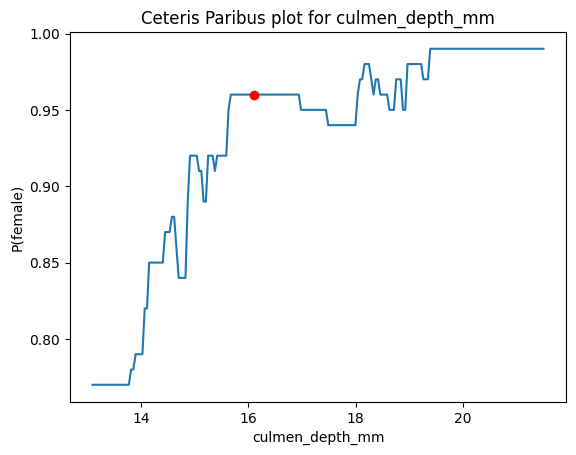

In [21]:
plt.plot(variable, 'P(female)', data=df_plot)
plt.scatter(variable, 'P(female)', data=actual, color='r', zorder=10)
plt.title(f'Ceteris Paribus plot for {variable}')
plt.xlabel(variable)
plt.ylabel('P(female)')

Observe the impact of all features

In [48]:
df = pl.read_csv('./data/bike_rental/day_cleaned.csv')

# Select columns
cols = [
  'holiday',
  'season',
  'weather_rmp',
  'workingday',
  'cnt_2d_bfr',
  'rel_hum',
  'temp_cel',
  'windspeed_kmh',
  'cnt'
]
df = df[cols]

df.head()

holiday,season,weather_rmp,workingday,cnt_2d_bfr,rel_hum,temp_cel,windspeed_kmh,cnt
i64,i64,i64,i64,i64,f64,f64,f64,i64
0,1,1,1,985,43.7273,8.050924,16.636703,1349
0,1,1,1,801,59.0435,8.2,10.739832,1562
0,1,1,1,1349,43.6957,9.305237,12.5223,1600
0,1,1,1,1562,51.8261,8.378268,6.0008684,1606
0,1,2,1,1600,49.8696,8.057402,11.304642,1510


In [49]:
# Split and train
y = df['cnt']
X = df.drop('cnt')

svr = SVR()
svr.fit(X, y)

SVR()

In [ ]:
# Creating the explainer and cp plots for all features
explainer = explain(svr, X.columns, X, y)

cp_profile = individual_variable_profile(explainer, X[1:5], y=y[1:5], variables=X.columns)
plot(cp_profile)

---

# Individual Conditional Expectation (ICE)